In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
import pandas as pd
from zipfile import ZipFile
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tensorflow.keras.utils import plot_model

In [2]:
zip_file = ZipFile('basketball_data.zip')
games_season_enriched, games_season, games_tourney = \
[pd.read_csv(zip_file.open(text_file.filename))
 for text_file in zip_file.infolist()
 if text_file.filename.endswith('.csv')]

games_season_enriched.shape, games_season.shape, games_tourney.shape

((4234, 10), (312178, 8), (4234, 9))

# Category embeddings

In chapter 1, our dataset of tournament games only contained about 4,000 rows. However, we have a much bigger dataset with over 300,000 regular season games. Let's see what we can learn from a much larger sample of data! In the 2 basketball datasets you will be using in this course, there are a little under 11,000 teams. Each team is coded as an integer starting with 1 and ending with 10,887. In this lesson, you will learn how to use those team IDs as inputs to a model that learns the strength of each team. 

In [3]:
games_season.team_1.sort_values().unique()

array([    0,     1,     2, ..., 10885, 10886, 10887])

In [4]:
len(games_season.team_1.unique())

10888

Categorical embeddings are an advanced type of layer, only available in deep learning libraries. They are extremely useful for dealing with high cardinality categorical data. In this dataset, the team ID variable has high cardinality. Embedding layers are also very useful for dealing with text data, such as in Word2vec models, but that is beyond the scope of this course. To model these teams in the basketball data, you'll use a very simple model that learns a "strength" rating for each team and uses those ratings to make predictions. To map the integer team IDs to a decimal rating, we will use an embedding layer. 

* Input: integers
* Output: floats
* Note: Increased dimensionality: output layer flattens back to 2D

Input layer (integer) -> Embedding Layer (lookup table) -> Output Layer (float)

## Inputs

To get started with category embeddings, you will need an input layer. In this case, your input is a single number, ranging from 1 to 10,887, which represents each team's unique ID. Note that this dataset covers about 30 years of data, and has about 400 unique schools, giving us close to 12,000 IDs. We only have about 11,000 of those year/team combinations, because not every school has a basketball team every year. 

In [5]:
from tensorflow.keras.layers import Input
input_tensor = Input(shape=(1,))
input_tensor

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_1')>

## Embedding Layer

To create an embedding layer, use the Embedding() function from tensorflow.keras.layers. Since you have 10,887 unique teams in the dataset, you define the input dimension of the embedding layer as 10,887. As you are representing each team as a single integer, use an input length of 1. You want to produce a single team strength rating, so use an output dimension of 1. Finally, name your layer, so you can easily find it when looking at the model summary, or plot. To use the embedding layer, connect it to the tensor produced by the input layer. This will produce an embedding output tensor.

In [6]:
from tensorflow.keras.layers import Embedding
input_tensor = Input(shape=(1,))
n_teams = len(games_season.team_1.unique()) # 10888 not 10887
embed_layer = Embedding(input_dim=n_teams,
                        input_length=1,
                        output_dim=1,
                        name='Team-Strength-Lookup')
embed_tensor = embed_layer(input_tensor)
embed_tensor

<KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Team-Strength-Lookup')>

## Flattening

Embedding layers increase the dimensionality of your data. The input CSV has two dimensions (rows and columns), but embedding layers add a third dimension. **This third dimension can be useful when dealing with images and text, so it is not as relevant to this course.** Therefore, we use the flatten layer to flatten the embeddings from 3D to 2D. The flatten layer is also the output layer for the embedding process. **Flatten layers are an advanced layer for deep learning models and can be used to transform data from multiple dimensions back down to two dimensions. They are useful for dealing with time series data, text data, and images.**

In [7]:
from tensorflow.keras.layers import Flatten
flatten_tensor = Flatten()(embed_tensor)
flatten_tensor

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten')>

## Put it all together

In [8]:
from tensorflow.keras.models import Model
input_tensor = Input(shape=(1,))
n_teams = len(games_season.team_1.unique()) # 10888 not 10887
embed_layer = Embedding(input_dim=n_teams,
                        input_length=1,
                        output_dim=1,
                        name='Team-Strength-Lookup')
embed_tensor = embed_layer(input_tensor)
flatten_tensor = Flatten()(embed_tensor)
model = Model(input_tensor, flatten_tensor)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 Team-Strength-Lookup (Embed  (None, 1, 1)             10888     
 ding)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 1)                 0         
                                                                 
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


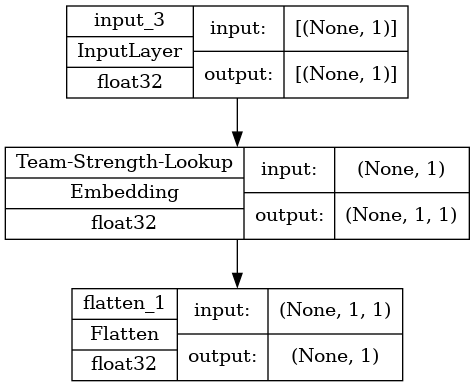

In [9]:
plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_dtype=True,
           # show_layer_names=True, # default True, others False
           expand_nested=True,
           show_layer_activations=True)

## Exercises

### Define team lookup

Shared layers allow a model to use the same weight matrix for multiple steps. In this exercise, you will build a "team strength" layer that represents each team by a single number. You will use this number for both teams in the model. The model will learn a number for each team that works well both when the team is team_1 and when the team is team_2 in the input data.

The games_season DataFrame is available in your workspace.

In [10]:
# Count the unique number of teams
n_teams = games_season['team_1'].unique().shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

The embedding layer is a lot like a dictionary, but your model learns the values for each key.

### Define team model

The team strength lookup has three components: an input, an embedding layer, and a flatten layer that creates the output.

If you wrap these three layers in a model with an input and output, you can re-use that stack of three layers at multiple places.

Note again that the weights for all three layers will be shared everywhere we use them.

In [11]:
# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')
team_strength_model.summary()

Model: "Team-Strength-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 Team-Strength (Embedding)   (None, 1, 1)              10888     
                                                                 
 flatten_2 (Flatten)         (None, 1)                 0         
                                                                 
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


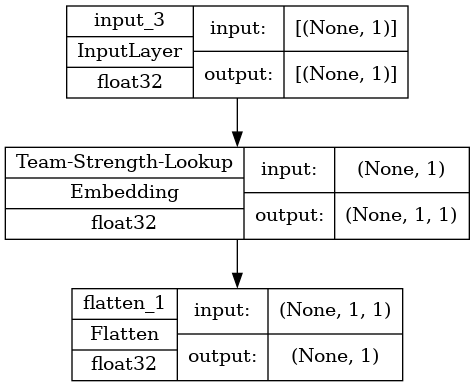

In [12]:
plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_dtype=True,
           # show_layer_names=True, # default True, others False
           expand_nested=True,
           show_layer_activations=True)

The model will be reusable, so you can use it in two places in your final model.

# Shared layers
* Require the functional API
* Very flexible

In this chapter, you will create a model with two inputs: one for each team in the basketball dataset. However, you want these two teams to each use the same embedding layer you defined in the previous lesson. Accomplishing this requires a shared layer. 

## Shared layers

To create a shared layer, you must first create two (or more) inputs, each of which will be passed to the shared layer. In this case, you will use two inputs.

In [13]:
input_tensor_1 = Input((1,))
input_tensor_2 = Input((1,))

Once you have two inputs, the magic of the Keras functional API becomes apparent. Recall from chapter 1 that the Dense() function returns a function as its output. This function, which Dense() outputs, takes a tensor as input and produces a tensor as output. You can use the same Dense() function to create a shared layer! Doing so is as simple as calling the function twice, with a different input tensor each time.

In [14]:
from tensorflow.keras.layers import Dense
shared_layer = Dense(1)
output_tensor_1 = shared_layer(input_tensor_1)
output_tensor_2 = shared_layer(input_tensor_2)

## Sharing multiple layers as a model

Recall the category embedding model we made in the previous lesson. This model first embeds an input and then flattens it. You can also share models, not just layers. This is really cool and is part of what makes the functional API so useful. You can define modular components of models and then reuse them. We define an embedding layer and wrap it in a model. We then define 2 input tensors, and pass each one to the same model, producing 2 output tensors. This will use the same model, with the same layers and the same weights, for mapping each input to its corresponding output.

In [15]:
input_tensor = Input(shape=(1,))
n_teams = len(games_season.team_1.unique()) # 10888 not 10887
embed_layer = Embedding(input_dim=n_teams,
                        input_length=1,
                        output_dim=1,
                        name='Team-Strength-Lookup')

embed_tensor = embed_layer(input_tensor)
flatten_tensor = Flatten()(embed_tensor)
model = Model(input_tensor, flatten_tensor)

input_tensor_1 = Input((1,))
input_tensor_2 = Input((1,))
output_tensor_1 = model(input_tensor_1)
output_tensor_2 = model(input_tensor_2)

## Exercises

### Defining two inputs

In this exercise, you will define two input layers for the two teams in your model. This allows you to specify later in the model how the data from each team will be used differently.

In [16]:
# Input layer for team 1
team_in_1 = Input((1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input((1,), name='Team-2-In')

These two inputs will be used later for the shared layer.

### Lookup both inputs in the same model

Lookup both inputs in the same model

Now that you have a team strength model and an input layer for each team, you can lookup the team inputs in the shared team strength model. The two inputs will share the same weights.

In this dataset, you have 10,888 unique teams. **You want to learn a strength rating for each team, such that if any pair of teams plays each other, you can predict the score, even if those two teams have never played before**. Furthermore, you want the strength rating to be the same, regardless of whether the team is the home team or the away team.

To achieve this, you use a shared layer, defined by the re-usable model (team_strength_model()) you built in exercise 3 and the two input layers (team_in_1 and team_in_2) from the previous exercise, all of which are available in your workspace.

In [17]:
# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

Now your model knows how strong each team is.

# Merge layers

Now that you've got multiple inputs and a shared layer, you need to combine your inputs into a single layer that you can use to predict a single output. This requires a Merge layer. Merge layers allow you to define advanced, non-sequential network topologies. This can give you a lot of flexibility to creatively design networks to solve specific problems.

There are many kinds of merge layers available in Keras. Add, Subtract, and Multiply layers do simple arithmetic operations by element on the input layers, and require them to be the same shape. For example, if we wanted to multiply our team strength ratings together, we could use a Multiply layer. Concatenate layers simply append the 2 layers together, similar to the hstack() function from numpy. Unlike the other merge layers, the Concatenate layer can operate on layers with different numbers of columns.

* Add
* Subtract
* Multiply
* Concatenate

Let's build a simple Keras model that takes in two numbers and adds them together. You accomplish this by defining two input layers and using the Add layer to add them together.  

In [18]:
from tensorflow.keras.layers import Input, Add
in_tensor_1 = Input((1,))
in_tensor_2 = Input((1,))
out_tensor = Add()([in_tensor_1, in_tensor_2])

If you'd like to add together many inputs, you can pass a list with more than two elements to an Add layer. Note that all of the inputs are required to have the same shape, so they can be combined element-wise. The Subtract and Multiply layers work the same way.

In [19]:
in_tensor_3 = Input((1,))
out_tensor = Add()([in_tensor_1, in_tensor_2, in_tensor_3])

## Create the model

Now you can wrap the output from your Add layer inside a Model, which will then allow you to fit it to data. Note that the model takes in a list of inputs because it has more than one input. 

In [20]:
from tensorflow.keras.models import Model
model = Model([in_tensor_1, in_tensor_2, in_tensor_3], out_tensor)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 add_1 (Add)                    (None, 1)            0           ['input_10[0][0]',               
                                                                  'input_11[0][0]',         

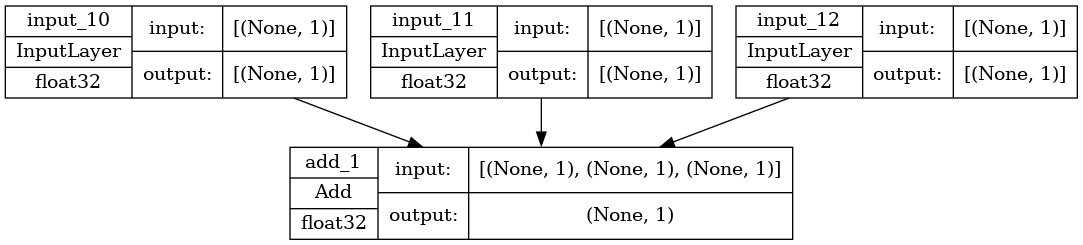

In [21]:
plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_dtype=True,
           # show_layer_names=True, # default True, others False
           expand_nested=True,
           show_layer_activations=True)

## Compile the model

In [22]:
model.compile(optimizer='adam', loss='mean_absolute_error')

## Exercises

### Output layer using shared layer

Now that you've looked up how "strong" each team is, subtract the team strengths to determine which team is expected to win the game.

This is a bit like the seeds that the tournament committee uses, which are also a measure of team strength. But rather than using seed differences to predict score differences, you'll use the difference of your own team strength model to predict score differences.

The subtract layer will combine the weights from the two layers by subtracting them.

In [23]:
# Import the Subtract layer from tensorflow.keras
from tensorflow.keras.layers import Subtract

# Create a subtract layer using the inputs from the previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

This setup subracts the team strength ratings to determine a winner.

### Model using two inputs and one output

Now that you have your two inputs (team id 1 and team id 2) and output (score difference), you can wrap them up in a model so you can use it later for fitting to data and evaluating on new data.

Your model will look like the following diagram:

In [24]:
# Subtraction layer from previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Team-1-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-2-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-Strength-Model (Functiona  (None, 1)           10888       ['Team-1-In[0][0]',              
 l)                                                               'Team-2-In[0][0]']              
                                                                                                  
 subtract_1 (Subtract)          (None, 1)            0           ['Team-Strength-Model[0][0]

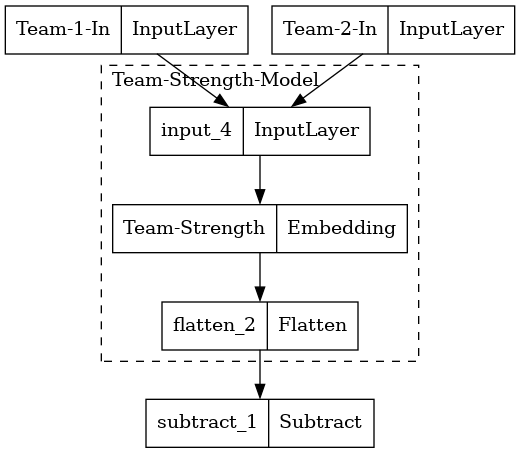

In [25]:
plot_model(model,
           to_file='model.png',
           # show_shapes=True,
           # show_dtype=True,
           # show_layer_names=True, # default True, others False
           expand_nested=True,
           # show_layer_activations=True
          )

Now your model is finalized and ready to fit to data.

# Fitting and Predicting with multiple inputs

## Fit with multiple inputs

    model.fit([data_1, data_2], target)

## Predict with multiple inputs

    model.predict([np.array([[1]]), np.array([[2]])])
    array([[3.]], dtype=float32)
    model.predict([np.array([[42]]), np.array([[119]])])
    array([[161.]], dtype=float32)

## Evaluate with multiple inputs

    model.evaluate([np.array([[-1]]), np.array([[-2]])], np.array([[-3]]))

**Multiple inputs let you do data pre-processing as part of the model you learn!**

## Exercises

### Fit the model to the regular season training data

Now that you've defined a complete team strength model, you can fit it to the basketball data! Since your model has two inputs now, you need to pass the input data as a list.

In [26]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2],
          games_season['score_diff'],
          epochs=1,
          batch_size=2048,
          validation_split= 0.1,
          verbose=True)

138/138 [==============================] - 0s 1ms/step - loss: 12.1203 - val_loss: 11.8382


### Evaluate the model on the tournament test data

The model you fit to the regular season data (model) in the previous exercise and the tournament dataset (games_tourney) are available in your workspace.

In this exercise, you will evaluate the model on this new dataset. This evaluation will tell you how well you can predict the tournament games, based on a model trained with the regular season data. This is interesting because many teams play each other in the tournament that did not play in the regular season, so this is a very good check that your model is not overfitting.

In [30]:
# Get team_1 from the tournament data
input_1 = games_tourney['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney['team_2']

# Evaluate the model using these inputs
print(model.evaluate([input_1, input_2], games_tourney['score_diff'], verbose=False))

11.682377815246582
